In [1]:
!pip install -q aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 989 kB/s 
     |████████████████████████████████| 209 kB 14.6 MB/s 
     |████████████████████████████████| 170 kB 53.6 MB/s 
     |████████████████████████████████| 76 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 947 kB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
API_KEY = '' #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [3]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c tree-segmentation -o data

test.zip:   0%|          | 0.00/316M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/402M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [5]:
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch pytorch-argus

     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 376 kB 63.3 MB/s 


In [19]:
images, segmentations = [], []

for i in range(len(os.listdir('/content/data/train/image'))):
    images.append(f'{i}.jpg')
    segmentations.append(f'{i}.png')

import pandas as pd
df = pd.DataFrame({
    'image': images,
    'segmentation': segmentations
})
df.to_csv('train_df.csv', index=False)

test_images = [f'{i}.jpg' for i in range(len(os.listdir('/content/data/test/image')))]
test_df = pd.DataFrame({
    'image': test_images
})
test_df.to_csv('test_df.csv', index=False)

In [1]:
!pip install -qU albumentations
import albumentations as albu
from albumentations.pytorch import ToTensorV2
# Pytorch 
import torch
from torch import nn
import segmentation_models_pytorch as smp
import argus
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Reading Dataset, vis and miscellaneous
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm.notebook import tqdm
import cv2
from natsort import natsorted
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:
class TreeSegmentationDataset(Dataset):
    def __init__(self, df, main_directory, train=True, transform=None):
        self.main_directory = main_directory
        self.transform = transform         
        self.train = train
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(f'{self.main_directory}/image/{self.df.image.values[idx]}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.train == True:
            mask = cv2.imread(f'{self.main_directory}/segmentation/{self.df.segmentation.values[idx]}')
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            if self.transform:
                augmentation = self.transform(image=img, mask=mask)
                img = augmentation['image'].float()
                mask = augmentation['mask'].float()
                mask = mask.unsqueeze(0)

            return img, mask / 255

        else:
            if self.transform:
                img = self.transform(image=img)['image'].float()
            return img

In [3]:
def get_transforms(data=''):
    if data == 'train':
        return albu.Compose([
                             albu.Flip(),
                             albu.RandomRotate90(p=0.2),
                             albu.ShiftScaleRotate(p=0.3, border_mode=cv2.BORDER_REFLECT),
                             albu.OpticalDistortion(p=0.1),
                             albu.GridDistortion(p=0.1),
                             albu.HueSaturationValue(hue_shift_limit=7, sat_shift_limit=5, val_shift_limit=7, p=0.1),
                             albu.CLAHE(p=0.15),
                             albu.RandomBrightnessContrast(p=0.3),
                             albu.RandomGamma(p=0.15),
                             ToTensorV2()
        ])
    elif data == 'valid':
        return albu.Compose([
                             ToTensorV2()
        ])

In [4]:
def get_UnetPlusPlus():
    model =  smp.UnetPlusPlus(
                 encoder_name='efficientnet-b4',
                 in_channels=3,
                 classes=1)
    return model

In [5]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [6]:
df = pd.read_csv('train_df.csv')
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = TreeSegmentationDataset(train_df, '/content/data/train', transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2, shuffle=True, drop_last=True)

valid_dataset = TreeSegmentationDataset(valid_df, '/content/data/train', transform=get_transforms(data='valid'))
valid_loader = DataLoader(valid_dataset, batch_size=4, num_workers=2, shuffle=True, drop_last=True)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model = get_UnetPlusPlus().to(device)

num_epochs = 15

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-3},
    {'params': model.encoder.parameters(), 'lr': 1e-3}
])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.15, patience=1, verbose=1)
diceloss = DiceLoss()
best_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, mask = data
        img = img.to(device)
        mask = mask.to(device)
        
        outputs = model(img)
    
        loss = diceloss(outputs, mask)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    train_loss /= len(train_loader)
    scheduler.step(train_loss)

    model.eval()
    valid_loss = 0
        
    for data in valid_loader:
        img, mask = data
        img = img.to(device)
        mask = mask.to(device)
        
        outputs = model(img)
    
        loss = diceloss(outputs, mask)
        
        valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    
    print(f"EPOCH: {epoch + 1}, train_loss: {train_loss}  valid_loss: {valid_loss}")

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model, "model.pth")
        print(f"Save best loss: {best_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1, train_loss: 0.1352661194205284  valid_loss: 0.08884255456924438
Save best loss: 0.08884255456924438
EPOCH: 2, train_loss: 0.08411040461063385  valid_loss: 0.0723176109790802
Save best loss: 0.0723176109790802
EPOCH: 3, train_loss: 0.07404085010290146  valid_loss: 0.0771013126373291
EPOCH: 4, train_loss: 0.07120756381750107  valid_loss: 0.0643238446712494
Save best loss: 0.0643238446712494
EPOCH: 5, train_loss: 0.06942180770635605  valid_loss: 0.0628611900806427
Save best loss: 0.0628611900806427
EPOCH: 6, train_loss: 0.06755454140901565  valid_loss: 0.06161831831932068
Save best loss: 0.06161831831932068
EPOCH: 7, train_loss: 0.06716379100084305  valid_loss: 0.0665733199119568
EPOCH: 8, train_loss: 0.06601253503561019  valid_loss: 0.06006712627410889
Save best loss: 0.06006712627410889
EPOCH: 9, train_loss: 0.06578443276882172  valid_loss: 0.059597071170806884
Save best loss: 0.059597071170806884
EPOCH: 10, train_loss: 0.06540063381195069  valid_loss: 0.059426395177841186
Sav

In [8]:
model = torch.load('model.pth')
model.eval()
model.to(device)

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [9]:
test_df = pd.read_csv('test_df.csv')
test_dataset = TreeSegmentationDataset(
    test_df,
    main_directory="data/test",
    train=False,
    transform=get_transforms(data='valid')
)
test_loader = DataLoader(test_dataset, batch_size=4, num_workers=1, shuffle=False, drop_last=False)

In [10]:
predictions = []

for images in tqdm(test_loader):
    images = images.to(device)
    prediction = model.predict(images)
    predictions.extend(prediction.cpu().numpy())

  0%|          | 0/1250 [00:00<?, ?it/s]

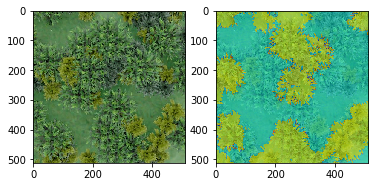

In [11]:
# Change the channel ordering
image = np.moveaxis(images[0].cpu().numpy()/255, 0, -1)

# Showing the image
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(image, 'gray', interpolation='none')
plt.imshow(predictions[-1][0], 'jet', interpolation='none', alpha=0.5)
plt.show()

In [12]:
!rm -rf segmentation
!mkdir segmentation

for n, img in tqdm(enumerate(predictions), total=len(predictions)):

    img = img[0]

    _, img = cv2.threshold(img, 0.4, 1, cv2.THRESH_BINARY)
    img = img * 255

    # Making sure the pixels are only 0 and 255 in the image. 
    img = Image.fromarray(img.astype(np.uint8))
    img

    img.save(os.path.join("segmentation", f"{n}.png"))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
!aicrowd notebook submit -c tree-segmentation -a segmentation --no-verify